# Light Multi-Channel ALS Demo with Toyblocks Scene
Notebook: Hannah Weiser & Sina Zumstein, 2023

This demo scene showcases various toyblock models scanned by airborne laserscanning. We will use the command-line access of HELIOS++ to run the simulation, and use Python just for displaying the input XMLs and the resulting point clouds.



In [1]:
import sys, os
from pathlib import Path
from IPython.display import Code

current_folder = globals()["_dh"][0]
helios_path = str(Path(current_folder).parent)
sys.path.append(helios_path)  # add helios-plusplus directory to PATH
import pyhelios

from pyhelios.util.xmldisplayer import display_xml, find_playback_dir

## Survey
Let us look at the XML files in the simulation. First, we investigate the survey XML file, `light_als_toyblocks_multiscanner.xml`:

In [2]:
os.chdir(helios_path)
Code(display_xml(r'data\surveys\demo\light_als_toyblocks_multiscanner.xml'), language='XML')

<document>
	<platformSettings id="platform1" movePerSec_m="30" z="100.0" />
    <scannerSettings active="true" id="scanner1" pulseFreq_hz="10000" scanAngle_deg="20.0" scanFreq_hz="100" trajectoryTimeInterval_s="0.01" />
    <survey name="light_toyblocks_als" platform="data/platforms.xml#sr22" scanner="data/scanners_als.xml#livox-mid-100" scene="data/scenes/toyblocks/light_toyblocks_scene.xml#light_toyblocks_scene">
	
		<leg>
			<platformSettings x="-30.0" y="-50.0" template="platform1" />
			<scannerSettings template="scanner1" />
		</leg>
		<leg>
			<platformSettings x="70.0" y="-50.0" template="platform1" />
			<scannerSettings template="scanner1" active="false" />
		</leg>
		<leg>
			<platformSettings x="70.0" y="0.0" template="platform1" />
			<scannerSettings template="scanner1" />
		</leg>
		<leg>
			<platformSettings x="-30.0" y="0.0" template="platform1" />
			<scannerSettings template="scanner1" active="false" />
		</leg>
	</survey>
</document>

We can see that there are four `leg` elements which define the waypoints of the platform (`sr22` airplane) trajectory and the speed between these waypoints (`movePerSec_m`). Since the scanner does not record any data between the second and the third leg (`active="false"`), there are only two flight strips.

## Scanner

Next we will have a look at the scanner that is placed on the platform. This is the `livox-mid-100` defined in `data/scanners_als.xml` as shown in the survey XML.

In [3]:
Code(display_xml(r'data/scanners_als.xml', 'livox-mid-100'), language='XML')

<scanner id="livox-mid-100" accuracy_m="0.02" beamDivergence_rad="0.0027" name="livox-mid-100" optics="risley" pulseFreqs_Hz="50000" pulseLength_ns="4" rangeMin_m="2" scanAngleMax_deg="35" scanAngleEffectiveMax_deg="35" rotorFreq1_Hz="7294" rotorFreq2_Hz="-4664" wavelength_nm="905">
		<channels>
			<channel id="0">
				<FWFSettings beamSampleQuality="3" />	
				<beamOrigin x="0" y="0" z="0">
					<rot axis="z" angle_deg="-30" /> 
				</beamOrigin>
				
			</channel>
			<channel id="1">
				<FWFSettings beamSampleQuality="3" />
				<beamOrigin x="0" y="0" z="0">
					
				</beamOrigin>
			</channel>
			<channel id="2">
				<FWFSettings beamSampleQuality="3" />
				<beamOrigin x="0" y="0" z="0">
					<rot axis="z" angle_deg="30" /> 
				</beamOrigin>
			</channel>
		</channels>
		<FWFSettings beamSampleQuality="3" />
	</scanner>

Besides the typical properties, such as `beamDivergence_rad` or `accuracy`, we see a special feature: The scanner has three channels with a different `beamOrigin` each. This way, the multi-channel laser scanner Livox Mid-100 is simulated, which has three LiDAR sensors with overlapping fields of view.

<center><img src=".\images\Livox_img.png" alt="Livox" title="Livox technical figure" width="500">

<i>Multi-channel laser scanner Livox Mid-100. Source: [Livox datasheet](https://www.livoxtech.com/3296f540ecf5458a8829e01cf429798e/downloads/20190530/Livox%20Mid-100%20Quick%20Start%20Guide%20multi%20v1.4.pdf).</i></center>

## Scene

Now we will have a look at the scene, `light_toyblocks_scene`in `data/scenes/toyblocks/light_toyblocks_scene.xml`:

In [4]:
Code(display_xml(r'data/scenes/toyblocks/light_toyblocks_scene.xml','light_toyblocks_scene'))

<scene id="light_toyblocks_scene" name="LightToyblocksScene">
        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/basic/groundplane/groundplane.obj" />
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="70" />
            </filter>
			<filter type="translate">
				<param type="vec3" key="offset" value="20.0;0;0" />
			</filter>
        </part>
        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/toyblocks/cube.obj" />
            </filter>
			<filter type="scale">
                <param type="double" key="scale" value="1" />
            </filter>
        </part>
		<part>
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/toyblocks/cube.obj" />
            </filter>
			<filter type="rotate">
				<param key="rotation" type="rotation">
					<rot angle_deg="45" axis="z" />
				</param>
			</filter>
			<filter type="scale">
                <param type="double" key="scale" value="0.5" />
            </filter>
			<filter type="translate">
				<param type="integer" key="onGround" value="-1" />
				<param type="vec3" key="offset" value="-45.0;10.0;10" />
			</filter>
        </part>
    </scene>

This is a simple scene, consisting of a groundplane and two cubes. The cubes are loaded from the same file (`data/sceneparts/cube.obj`) with the `objloader` but the second one is additionally rotated, scaled and translated. 

## Executing the Simulation

Next, we will run the simulation. In Jupyter Notebooks, we can run external commands with the `!command` syntax, but you can also just run it from the command line. In this demo we will run the simulation twice: One time with all three scanners working together, producing one output per strip and one time with the `--splitByChannel` argument, which will create individual outputs for each scanner. We start with the joined simulation.

In [5]:
!"run/helios.exe" data/surveys/demo/light_als_toyblocks_multiscanner.xml
output_path_joined = find_playback_dir(r"data\surveys\demo\light_als_toyblocks_multiscanner.xml")

HELIOS++ VERSION 1.1.1

CWD: "H:\helios4pyhelios\helios"
seed: AUTO
surveyPath: "data/surveys/demo/light_als_toyblocks_multiscanner.xml"
assetsPath: "assets/"
outputPath: "output/"
writeWaveform: 0
calcEchowidth: 0
fullWaveNoise: 0
splitByChannel: 0
parallelization: 1
njobs: 0
chunkSize: 32
warehouseFactor: 4
platformNoiseDisabled: 0
legNoiseDisabled: 0
rebuildScene: 0
lasOutput: 0
las10: 0
fixedIncidenceAngle: 0
gpsStartTime: 
kdtType: 4
kdtJobs: 0
kdtGeomJobs: 0
sahLossNodes: 32

xmlDocFilename: light_als_toyblocks_multiscanner.xml
xmlDocFilePath: data/surveys/demo
xmlDocFilename: scanners_als.xml
xmlDocFilePath: data
Using default value for attribute 'averagePower_w' : 4
Using default value for attribute 'beamQualityFactor' : 1
Using default value for attribute 'opticalEfficiency' : 0.99
Using default value for attribute 'receiverDiameter_m' : 0.15
Using default value for attribute 'atmosphericVisibility_km' : 23
Using default value for attribute 'binSize_ns' : 0.25
Using default va

In [6]:
!"run/helios.exe" data/surveys/demo/light_als_toyblocks_multiscanner.xml --splitByChannel
output_path_split_by_channel = find_playback_dir(r"data\surveys\demo\light_als_toyblocks_multiscanner.xml")

HELIOS++ VERSION 1.1.1

CWD: "H:\helios4pyhelios\helios"
seed: AUTO
surveyPath: "data/surveys/demo/light_als_toyblocks_multiscanner.xml"
assetsPath: "assets/"
outputPath: "output/"
writeWaveform: 0
calcEchowidth: 0
fullWaveNoise: 0
splitByChannel: 1
parallelization: 1
njobs: 0
chunkSize: 32
warehouseFactor: 4
platformNoiseDisabled: 0
legNoiseDisabled: 0
rebuildScene: 0
lasOutput: 0
las10: 0
fixedIncidenceAngle: 0
gpsStartTime: 
kdtType: 4
kdtJobs: 0
kdtGeomJobs: 0
sahLossNodes: 32

xmlDocFilename: light_als_toyblocks_multiscanner.xml
xmlDocFilePath: data/surveys/demo
xmlDocFilename: scanners_als.xml
xmlDocFilePath: data
Using default value for attribute 'averagePower_w' : 4
Using default value for attribute 'beamQualityFactor' : 1
Using default value for attribute 'opticalEfficiency' : 0.99
Using default value for attribute 'receiverDiameter_m' : 0.15
Using default value for attribute 'atmosphericVisibility_km' : 23
Using default value for attribute 'binSize_ns' : 0.25
Using default va

## The results 
Now we can display the 3D plots. 

### 1) Full point cloud
We start with the point cloud of the first simuation and we color it by **object ID**.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path

print("Loading points from", Path(output_path_joined).relative_to(helios_path).as_posix())


strip_1 = np.loadtxt(Path(output_path_joined) / 'leg000_points.xyz')
strip_2 = np.loadtxt(Path(output_path_joined) / 'leg002_points.xyz')

#stacking the strips 
strips= np.vstack((strip_1, strip_2))

traj_1 = np.loadtxt(Path(output_path_joined) / 'leg000_trajectory.txt')
traj_2 = np.loadtxt(Path(output_path_joined) / 'leg002_trajectory.txt')

traj = np.vstack((traj_1[:, :3], traj_2[:, :3]))

Loading points from output/light_toyblocks_als/2023-01-23_13-56-09


In [8]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius]) 
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

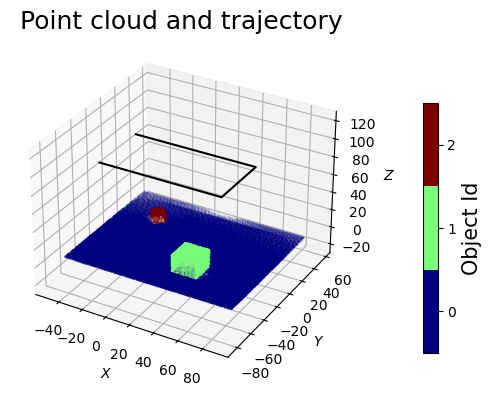

In [9]:
# Matplotlib figures.
fig = plt.figure(figsize=(15,10))


#settings for a discrete colorbar
N=3
cmap=plt.get_cmap('jet',N)

# Scatter plot of first scanner (coloured by hitObjectId).
ax = fig.add_subplot(1,3,1, projection='3d')
sc = ax.scatter(strips[:, 0], strips[:, 1], strips[:, 2], c=strips[:, 8], cmap=cmap, s=0.02, label='scene')

# Plot of trajectory.
ax.plot(traj[:,0], traj[:,1], traj[:,2], c = 'black', label = 'scanner trajectory')

# Add axis labels.
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')

set_axes_equal(ax)    

# Set title.
ax.set_title(label='Point cloud and trajectory',fontsize=18)

cax = plt.axes([0.4, 0.35, 0.01, 0.25])
cbar = plt.colorbar(sc, cax=cax, ticks=[1-2/3, 1, 1+2/3])

cbar.set_label("Object Id", fontsize=15)
cbar.ax.set_yticklabels(['0', '1', '2'])

# Display results
plt.show()


### 2) Separate point clouds by channel

Now we can create 3D plots for each scanner seperately.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

print("Loading points from", Path(output_path_split_by_channel).relative_to(helios_path).as_posix())

# we load the output of each scanner and strip seperately

strip_1_dev0 = np.loadtxt(Path(output_path_split_by_channel) / 'leg000_points_dev0.xyz')
strip_1_dev1 = np.loadtxt(Path(output_path_split_by_channel) / 'leg000_points_dev1.xyz')
strip_1_dev2 = np.loadtxt(Path(output_path_split_by_channel) / 'leg000_points_dev2.xyz')

strip_2_dev0= np.loadtxt(Path(output_path_split_by_channel) / 'leg002_points_dev0.xyz')
strip_2_dev1= np.loadtxt(Path(output_path_split_by_channel) / 'leg002_points_dev1.xyz')
strip_2_dev2= np.loadtxt(Path(output_path_split_by_channel) / 'leg002_points_dev2.xyz')

#stacking the strips for each scanner

strips_dev0 = np.vstack((strip_1_dev0, strip_2_dev0))
strips_dev1 = np.vstack((strip_1_dev1, strip_2_dev1))
strips_dev2 = np.vstack((strip_1_dev2, strip_2_dev2))

traj_1 = np.loadtxt(Path(output_path_split_by_channel) / 'leg000_trajectory.txt')
traj_2 = np.loadtxt(Path(output_path_split_by_channel) / 'leg002_trajectory.txt')

traj = np.vstack((traj_1[:, :3], traj_2[:, :3]))

Loading points from output/light_toyblocks_als/2023-01-23_13-56-10


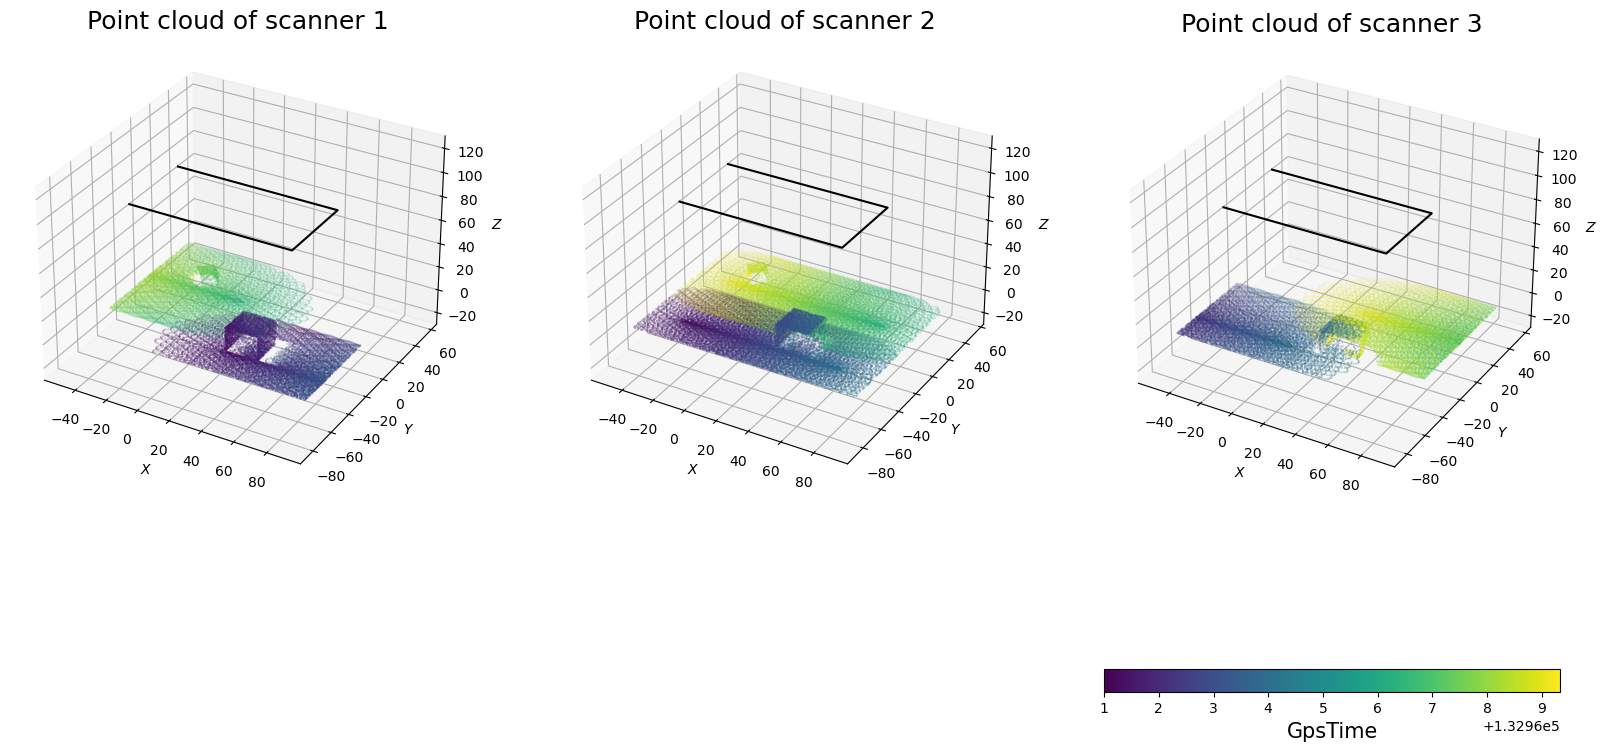

In [11]:
# Matplotlib figures.
fig = plt.figure(figsize=(20,15))

for i, strips in enumerate([strips_dev0, strips_dev1, strips_dev2]):

    # Scatter plot of points from respective scanner (coloured by GpsTime).
    ax = fig.add_subplot(1,3,i+1, projection='3d')
    sc = ax.scatter(strips[:, 0], strips[:, 1], strips[:, 2], c=strips[:, 10], cmap='viridis', s=0.02, label='scene')

    # Plot of trajectory.
    ax.plot(traj[:,0], traj[:,1], traj[:,2], c = 'black', label = 'scanner trajectory')

    # Add axis labels.
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')

    set_axes_equal(ax)    

    # Set title.
    ax.set_title(label=f'Point cloud of scanner {i+1}', fontsize=18)

cbar = plt.colorbar(sc, orientation='horizontal' , ax=ax)
cbar.set_label("GpsTime", fontsize=15)

# Display results
plt.show()